In [1]:
import numpy as np
# pandas
from pandas import read_csv
# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#teras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Accuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

In [3]:
seed = 13
np.random.seed(seed)


In [4]:
# load dataset
dataset = input('\nWhich is the name of the dataset? ')
dataframe = read_csv(dataset, header=0)
dataset = dataframe.values
#dataset = np.random.shuffle(dataset)
first_col = input("\nSelect first column: \n") #2
last_col = input('\nSelect last col: \n')          #15

X = dataset[:,int(first_col):int(last_col)].astype(float)   # columns from 3rd to 14th into X
Y = dataset[:,int(last_col)] #label column (15th) into Y 


Which is the name of the dataset? analysis.csv

Select first column: 
2

Select last col: 
15


In [5]:
#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

#One-hot encoding
transformed_Y = to_categorical(encoded_Y)

In [69]:
a = unique_labels(Y)

print(a)

['background' 'signal']


In [6]:
#Initialising NN
model = Sequential()

#First layer
model.add(Dense(8, activation='relu', input_shape=(13,)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Second layer
model.add(Dense(12, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2, activation='sigmoid'))


model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr= 0.0001),
              metrics=[Precision(name = 'precision'),
                       Recall(name = 'recall')
                      ]
             )

X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    transformed_Y,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    shuffle = True)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
epochs = 50
val_data = (X_test,Y_test)
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_precision', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history=model.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  shuffle = True,
                  validation_data=val_data,
                  callbacks = callbacks_list,
                  batch_size=150000)

Train on 3040026 samples, validate on 760007 samples
Epoch 1/50
3000000/3040026 [============================>.] - ETA: 0s - loss: 0.5784 - precision: 0.8251 - recall: 0.8480
Epoch 00001: val_precision improved from -inf to 0.93786, saving model to model_weights.h5
3040026/3040026 [==============================] - 2s 1us/sample - loss: 0.5785 - precision: 0.8250 - recall: 0.8471 - val_loss: 0.5132 - val_precision: 0.9379 - val_recall: 0.9670
Epoch 2/50
3000000/3040026 [============================>.] - ETA: 0s - loss: 0.5738 - precision: 0.8318 - recall: 0.8531
Epoch 00002: val_precision improved from 0.93786 to 0.93974, saving model to model_weights.h5
3040026/3040026 [==============================] - 2s 1us/sample - loss: 0.5738 - precision: 0.8318 - recall: 0.8530 - val_loss: 0.5096 - val_precision: 0.9397 - val_recall: 0.9678
Epoch 3/50
3000000/3040026 [============================>.] - ETA: 0s - loss: 0.5688 - precision: 0.8386 - recall: 0.8594
Epoch 00003: val_precision improve

Epoch 22/50
3000000/3040026 [============================>.] - ETA: 0s - loss: 0.4789 - precision: 0.9286 - recall: 0.9238
Epoch 00022: val_precision improved from 0.97501 to 0.97598, saving model to model_weights.h5
3040026/3040026 [==============================] - 2s 1us/sample - loss: 0.4789 - precision: 0.9285 - recall: 0.9235 - val_loss: 0.4312 - val_precision: 0.9760 - val_recall: 0.9762
Epoch 23/50
3000000/3040026 [============================>.] - ETA: 0s - loss: 0.4742 - precision: 0.9314 - recall: 0.9248
Epoch 00023: val_precision improved from 0.97598 to 0.97681, saving model to model_weights.h5
3040026/3040026 [==============================] - 2s 1us/sample - loss: 0.4741 - precision: 0.9314 - recall: 0.9248 - val_loss: 0.4271 - val_precision: 0.9768 - val_recall: 0.9764
Epoch 24/50
3000000/3040026 [============================>.] - ETA: 0s - loss: 0.4696 - precision: 0.9340 - recall: 0.9256
Epoch 00024: val_precision improved from 0.97681 to 0.97727, saving model to mode

3000000/3040026 [============================>.] - ETA: 0s - loss: 0.3801 - precision: 0.9616 - recall: 0.9510
Epoch 00044: val_precision did not improve from 0.97743
3040026/3040026 [==============================] - 2s 1us/sample - loss: 0.3801 - precision: 0.9617 - recall: 0.9510 - val_loss: 0.3443 - val_precision: 0.9774 - val_recall: 0.9772
Epoch 45/50
3000000/3040026 [============================>.] - ETA: 0s - loss: 0.3759 - precision: 0.9623 - recall: 0.9513
Epoch 00045: val_precision did not improve from 0.97743
3040026/3040026 [==============================] - 2s 1us/sample - loss: 0.3759 - precision: 0.9623 - recall: 0.9513 - val_loss: 0.3406 - val_precision: 0.9774 - val_recall: 0.9772
Epoch 46/50
3000000/3040026 [============================>.] - ETA: 0s - loss: 0.3716 - precision: 0.9631 - recall: 0.9531
Epoch 00046: val_precision did not improve from 0.97743
3040026/3040026 [==============================] - 2s 1us/sample - loss: 0.3716 - precision: 0.9631 - recall: 0.9

In [18]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [19]:
#compute predictions
predictions = model.predict(X_test)

y_pred = np.array([np.argmax(probas) for probas in predictions])
y_test = np.array([np.argmax(label) for label in Y_test])




In [46]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = [1, 0])
cm

array([[     2,  17178],
       [    81, 742746]])

In [71]:
classes = unique_labels(y_test, y_pred)
class_names = unique_labels(Y)

In [85]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          class_names = None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    if class_names is None:
        x_labels = y_labels = classes
    else:
        x_labels = y_labels = class_names
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=x_labels, yticklabels=y_labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[742746     81]
 [ 17178      2]]


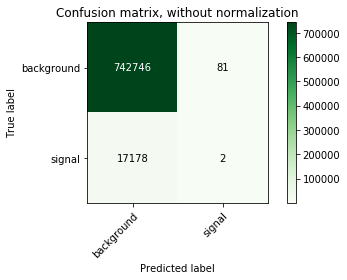

In [86]:
plot_confusion_matrix(y_test, y_pred, classes, class_names)

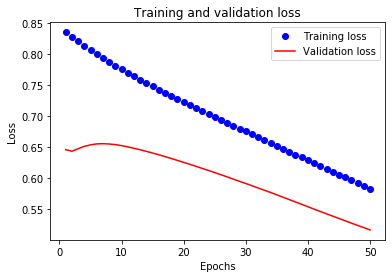

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

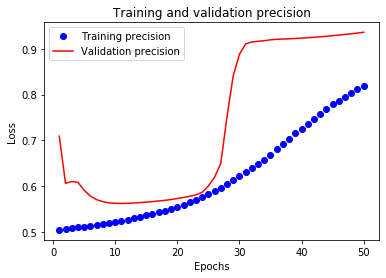

In [15]:
plt.clf()  #Clears the figure
prec = history.history['precision']
val_prec = history.history['val_precision']
plt.plot(epochs, prec, 'bo', label='Training precision')
plt.plot(epochs, val_prec, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

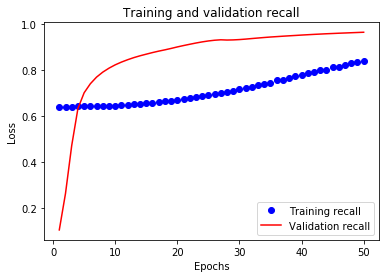

In [16]:
plt.clf()  #Clears the figure
rec = history.history['recall']
val_rec = history.history['val_recall']
plt.plot(epochs, rec, 'bo', label='Training recall')
plt.plot(epochs, val_rec, 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()